# Applying principal components analysis to images

### Introduction

Before working with deep CNN, it is a good idea to apply a simpler model to our dataset, to get an idea of the performances we should reach and eventually beat.
To do that, we will implement a basic pre-processing of the dataset, and compute the accuracy of a SVC on the vowels, the numerals and the consonants dataset. **Without fine tuning, we will demonstrate an accuracy of 97% on the numerals (10 classes), 91% on the vowels (12 classes) and 75% on the consonants (36 classes)**.

These results are made possible by the application of principal components analysis to the images. To understand how this method allows us to achieve this precision, we will display some of the PCA axis as images, to see the patterns that the PCA has uncovered.

### Loading the dataset

We will use a function defined in `load_data.py`, that return the dataset as a list of PIL images and a list of labels.
Just import the file and use it:

In [16]:
import load_data
from PIL import Image

In [136]:
consonants_img, consonants_labels = load_data.PIL_list_data('consonants')
vowels_img, vowels_labels = load_data.PIL_list_data('vowels')
numerals_img, numerals_labels = load_data.PIL_list_data('numerals')

Raw consonants loaded, 7380 obs of 37 classes
Raw vowels loaded, 2652 obs of 13 classes
Raw numerals loaded, 2880 obs of 11 classes


### Exploration and pre-processing

We define a small function to easily display some charaters, randomly sampled from our dataset. We observe that the numerals are very similar to the Arab ones, but that the vowels and consonants seems more complicated and will likely be more difficult to classify. The thickness of the character is variable, but all characters are black on a white support. The images will likely need few pre-processing steps: they are already centered on the image, adjusted so they fill the entire space, and all the images have the same size and resolution. As a result, this is a quite easy dataset and a method not specific to image classification (such as a support vector classifier) will likely gives a good accuracy.

Some unprocessed numerals:


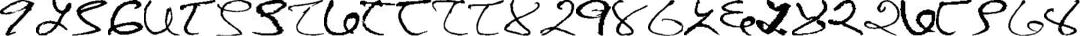

Some unprocessed vowels:


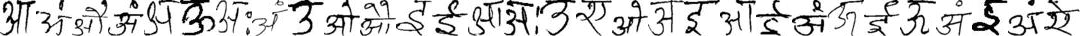

Some unprocessed consonants:


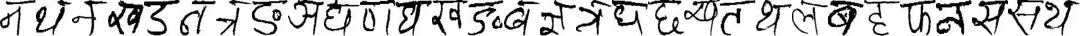

In [101]:
from IPython.display import display
from numpy import concatenate
from random import sample
from PIL import Image

def display_some(img_list, n=30, to_sample=True):
    if to_sample: 
        img_list = sample(img_list,n)
    display(Image.fromarray(concatenate(img_list,axis=1)))
    
print("Some unprocessed numerals:")
display_some(numerals_img)
print("Some unprocessed vowels:")
display_some(vowels_img)
print("Some unprocessed consonants:")
display_some(consonants_img)

Even if the images seems to be black and white, they are still RGB images. The first step is to convert these images to 'shades of greys' ones, reducing the dimension of the inputs from 36x36x3 to 36x36x1. A white pixel is represented by an integer value of 255, and a white one by a zero. Inverting the images, such as a stroke of the pen correpond to non-null values on the corresponding pixels usually leads to more stable results (It is worth noting that because we apply a PCA later, the final result is theoretically insensible to this manipulation).

Some inverted numerals:


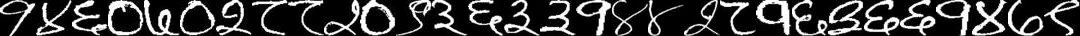

Some inverted vowels:


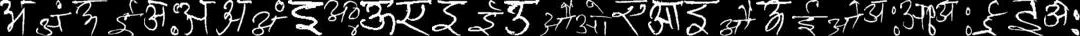

Some inverted consonants:


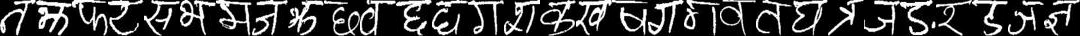

In [4]:
from PIL import ImageOps  

def pre_process(img_list):
    img_bw = [img.convert('LA') for img in img_list]
    return [ImageOps.invert(img) for img in img_list]

consonants_proc = pre_process(consonants_img)
vowels_proc = pre_process(vowels_img)
numerals_proc = pre_process(numerals_img)

print("Some inverted numerals:")
display_some(numerals_proc)
print("Some inverted vowels:")
display_some(vowels_proc)
print("Some inverted consonants:")
display_some(consonants_proc)

### From images to vectors

Most machine learning models will only undertand vectors of numbers as an input. Because of that, we must transform our images to vectors. To do so, we first flatten the matrix of the pixel values, transforming a 36x36 pixels picture to an vector of integers of size 1296. We should also rescale our vectors, so that a white pixel is represented by a value of 1 instead of 255. We apply this transformations to all of our images:

In [36]:
import numpy as np

def to_vectors(img_list, rescale=True):
    
    def vectorize_one_img(img):
        # Represent the image as a matrix of pixel weights, and flatten it
        flattened_img = np.asmatrix(img).flatten()
        # Rescaling by dividing by the maximum possible value of a pixel
        if rescale: flattened_img = np.divide(flattened_img,255.0)
        return np.asarray(flattened_img)[0]
    
    # Apply this transformation to all images of the input vector
    return [vectorize_one_img(img) for img in img_list]

consonants_inputs = to_vectors(consonants_proc)
vowels_inputs = to_vectors(vowels_proc)
numerals_inputs = to_vectors(numerals_proc)

### Choosing the best model

Here, we choose to use a support vector machine classifier (SVC) on the reduced features returned by a principal componant analysis (PCA). The SVC is well adapted when we have few samples (no more than 10000 points, and only 200 points per class here).

These classifiers have a lot of meta-parameters, but we will tune here only the C and gamma ones. We choose to use a gaussian kernel, the default one which works usually very well. We thus define a simple function that takes a vector of inputs and a vector of labels as arguments, test several sets of parameters, and return the best SVC found.
In order to do that, we use Scikit's GridSearch that will test all combinaisons of parameters from a dictionnary, compute an accuracy with a K-Fold, and return the best model.

In [126]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def best_SVC(X,y):
    # Initiate a SVC classifier with default parameters
    svc_model = SVC()
    # The values to test for the C and gamma parameters.
    param_dic = {'C':[1,10,100],
                'gamma':[0.001,0.005,0.01]}
    clf = GridSearchCV(svc_model, param_dic, n_jobs=-1)
    # Search for the best set of parameters for our dataset, using bruteforce
    clf.fit(X, y)
    print("Best parameters: ", clf.best_params_)
    # We return the best model found
    return clf.best_estimator_

### Computing the accuracy of the best model

#### Splitting the dataset

As usual, we split our dataset into a training set to train the model on, and a testing set to evaluate its results. We uses Scikit's train_test_split function that is straight-forward, and keep the default training/testing ratio of 0.8/0.2.

#### Using a PCA

Our input space is large: we have a dimension for each pixel of the picture: we thus have 1296 features by observation. We choose to use a PCA to reduce this number of dimensions to 16. PCA is a very usefull technique which can be applied sucessfully to image classification: see for instance the application of PCA and SVC to face recognition (http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html).

#### Computing the result

Our pipeline is very simple: given a list of inputs and a list of labels, we:
- Split the lists to obtain a training set and a testing set.
- We find the axis that maximise variance on the training set.
- We project the training and testing points on these axis.
- We find the SVC model that maximises the accuracy and fit it on the training set.
- We compute the accuracy of this model on the test set and return it

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
    
def benchmark(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pca = PCA(n_components = 16)
    pca.fit(X_train)
    reduced_X_train, reduced_X_test = pca.transform(X_train), pca.transform(X_test)
    
    best_model = best_SVC(X_train,y_train)
    predictions = best_model.predict(X_test)
    return accuracy_score(y_test, predictions)
    

In [127]:
score_on_numerals = benchmark(numerals_inputs, numerals_labels)
print("Best accuracy on numerals: {}".format(score_on_numerals))

score_on_vowels = benchmark(vowels_inputs, vowels_labels)
print("Best accuracy on vowels: {}".format(score_on_vowels))

score_on_consonants = benchmark(consonants_inputs, consonants_labels)
print("Best accuracy on consonants: {}".format(score_on_consonants))

('Best parameters: ', {'C': 10, 'gamma': 0.01})
Best accuracy on numerals: 0.972222222222
('Best parameters: ', {'C': 10, 'gamma': 0.01})
Best accuracy on vowels: 0.906485671192
('Best parameters: ', {'C': 10, 'gamma': 0.005})
Best accuracy on consonants: 0.745257452575


## Results

### Accuracy achieved:

On numerals, we achieve an accuracy of 97% on 10 classes. Obviously, this result is far better than random guessing, and could be a better benchmark for a more sophisticated algorithm. 
As one can expect, the model is less accurate when the number of classes is growing: only 91% on the vowels (13 classes) and 75% on the consonants (32 classes). From a human point of view, these characters also seems more complex than the numerals. As a result, a simple model like this on can perform well on character recognition if there is few classes and quite simple characters (like MNIST for instance). Otherwise, we should use a more adapted model such as CNN.

### Why does it (quite) work ?

Because the SVC is not designed for image recognition, as opposed to CNN, these good results could be surprising. Considering each pixel as a dimension have obvious drawbacks: a translation of one pixel for a character will leads to a very different point in the input vector space and, by opposition to CNN, most general machine learning algorithms don't take into account the relative positions of the pixels. This issue can be somehow mitigated by the use of a PCA.

### How does the PCA help ?

PCA is quite simple: it will find linear combinaisons of inputs, the PCA axis, such as the projection of our observations on these axis will have the maximum variance. In other words, it will find combinaisons of features that makes the datapoints very dinstinctive.

Knowing that, we can undertand better how the PCA can be applied in image reduction. Because two pixels that are close to each other will have a high covariance (they are very likely to have a similar color), they will be projected the same way on the PCA axis. Thus, applying a PCA to our images will allow us to keep some information about the relative positions of the pixels, and will greatly help our model to make more accurate predictions. 

To better understand this concept, we can visualize the axis of the PCA as an image, and see how the projection affects our inputs.

## Understanding the Principal Component Analysis on images

Most important features for numerals:


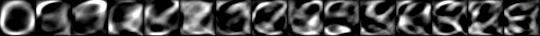

Most important features for vowels:


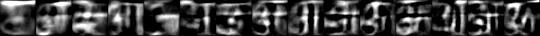

Most important features for consonants:


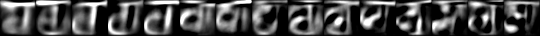

In [133]:
# Play with this parameter: the greater, the bigger the intensity of the feature on the image
Intensity = 3000

def display_features(images_vec, n_features):
    # Compute the PCA on our vector of images
    pca = PCA(n_components = n_features)
    pca.fit(images_vec)
    # Create a point on each axis of the PCA
    activate_features = np.multiply(np.eye(n_features),Intensity)
    # Go again in the original space so we can interpret the projections as images
    untransformed_features = [img.reshape(36,36) for img in
            pca.inverse_transform(activate_features)]
    # Paste all images sides by sides and display
    all_images = concatenate(untransformed_features, axis=1)
    display(Image.fromarray(np.matrix(all_images)).convert('RGB'))
    

print("Most important features for numerals:")
display_features(to_vectors(numerals_proc,rescale=False),15)

print("Most important features for vowels:")
display_features(to_vectors(vowels_proc,rescale=False),15)

print("Most important features for consonants:")
display_features(to_vectors(consonants_proc,rescale=False),15)
    

Original images:


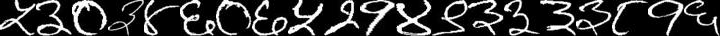

Projection on a PCA with 1 dimension(s)


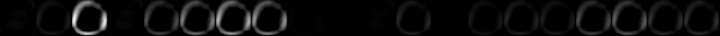

Projection on a PCA with 4 dimension(s)


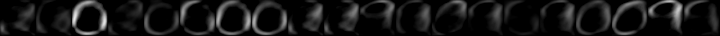

Projection on a PCA with 8 dimension(s)


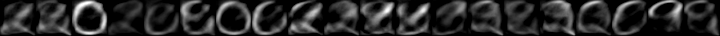

Projection on a PCA with 12 dimension(s)


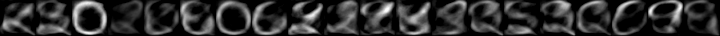

Projection on a PCA with 24 dimension(s)


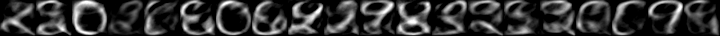

Projection on a PCA with 48 dimension(s)


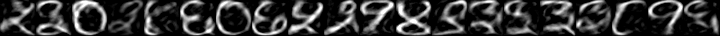

In [131]:
# Given a sample of images (as vector), display their projection on a PCA with n_axis
def display_inverse_PCA(sample, n_axis):
    # Define and fit on all the numerals
    pca = PCA(n_components = n_axis)
    pca.fit(numerals_inputs)
    # Project the sample on the PCA axis
    transformed_samples = pca.transform(sample)
    # Go again in the original space so we can interpret the projections as images
    untransformed_samples = [img.reshape(36,36) for img in
            pca.inverse_transform(transformed_samples)]
    # Paste all images sides by sides and display
    all_images = concatenate(untransformed_samples, axis=1)
    display(Image.fromarray(np.matrix(all_images)).convert('RGB'))
    
# Randomly select a sample of characters to work with
image_sample = sample(numerals_proc, 20)
# Transform the selected images as vectors, without rescaling them
vec_sample = to_vectors(image_sample, False)

# Display the results for some numbers of components
print("Original images:")
display_some(image_sample, n=0, to_sample=False)
for nb_components in (1,4,8,12,24,48):
    print("Projection on a PCA with {} dimension(s)".format(nb_components))
    display_inverse_PCA(vec_sample, nb_components)

